# Time series forecasting

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

In [2]:
year2010 = pd.read_excel('online_retail_II.xlsx','Year 2009-2010')
year2011 = pd.read_excel('online_retail_II.xlsx','Year 2010-2011')

# Data cleaning

In [3]:
# Convert 'InvoiceDate' to datetime format
year2010['InvoiceDate'] = pd.to_datetime(year2010['InvoiceDate'], format='%d/%m/%Y %H:%M')

year2010 = year2010[year2010['InvoiceDate'].dt.year == 2010]

year2010['Customer ID'].fillna('UNKNOWN',inplace=True)

# change dtype of Customer ID, Description, StockCode to string
year2010['Customer ID'] = year2010['Customer ID'].astype(str)
year2010['Description'] = year2010['Description'].astype(str)
year2010['StockCode'] = year2010['StockCode'].astype(str)

#clean invalid quantity, price and description
year2010 = year2010[(year2010['Quantity'] > 0) & (year2010['Price'] > 0) & (year2010['Description'] != '') & (year2010['StockCode'] != '')]

#clear stockcodes that start with alphabets (they are not products!)
year2010 = year2010[~year2010['StockCode'].str[0].str.isalpha()]

In [4]:
# Convert 'InvoiceDate' to datetime format
year2011['InvoiceDate'] = pd.to_datetime(year2011['InvoiceDate'], format='%d/%m/%Y %H:%M')

year2011 = year2011[year2011['InvoiceDate'].dt.year == 2011]

year2011['Customer ID'].fillna('UNKNOWN',inplace=True)

# change dtype of Customer ID, Description, StockCode to string
year2011['Customer ID'] = year2011['Customer ID'].astype(str)
year2011['Description'] = year2011['Description'].astype(str)
year2011['StockCode'] = year2011['StockCode'].astype(str)

#clean invalid quantity, price and description
year2011 = year2011[(year2011['Quantity'] > 0) & (year2011['Price'] > 0) & (year2011['Description'] != '') & (year2011['StockCode'] != '')]

#clear stockcodes that start with alphabets (they are not products!)
year2011 = year2011[~year2011['StockCode'].str[0].str.isalpha()]

# Feature engineering

In [5]:
year2010['TotalSales'] = year2010['Price'] * year2010['Quantity']

In [6]:
year2011['TotalSales'] = year2011['Price'] * year2011['Quantity']

In [7]:
year2010['TotalSales'].describe()

count    465353.000000
mean         19.419711
std          66.477599
min           0.060000
25%           4.200000
50%          10.170000
75%          17.700000
max       15818.400000
Name: TotalSales, dtype: float64

In [8]:
year2011['TotalSales'].describe()

count    486415.000000
mean         19.516604
std         279.078808
min           0.060000
25%           3.750000
50%           9.900000
75%          17.700000
max      168469.600000
Name: TotalSales, dtype: float64

# Remove outlier

In [9]:
upper_bound10 = year2010['TotalSales'].quantile(0.999994)
upper_bound11 = year2011['TotalSales'].quantile(0.999994)
print(upper_bound10)
print(upper_bound11)

5308.932506402783
9738.98952558603


Remove outlier so that 2010 and 2011 sales are in the same order of magnitude

In [10]:
df10 = year2010[year2010['TotalSales'] <= upper_bound10]
df11 = year2011[year2011['TotalSales'] <= upper_bound11]

In [11]:
df10 = df10[['InvoiceDate', 'TotalSales']]

In [12]:
df11 = df11[['InvoiceDate', 'TotalSales']]

In [13]:
df10.reset_index(drop=True, inplace=True)
df11.reset_index(drop=True, inplace=True)

reset index after outlier are removed

# Compare sales in year2010 and year2011

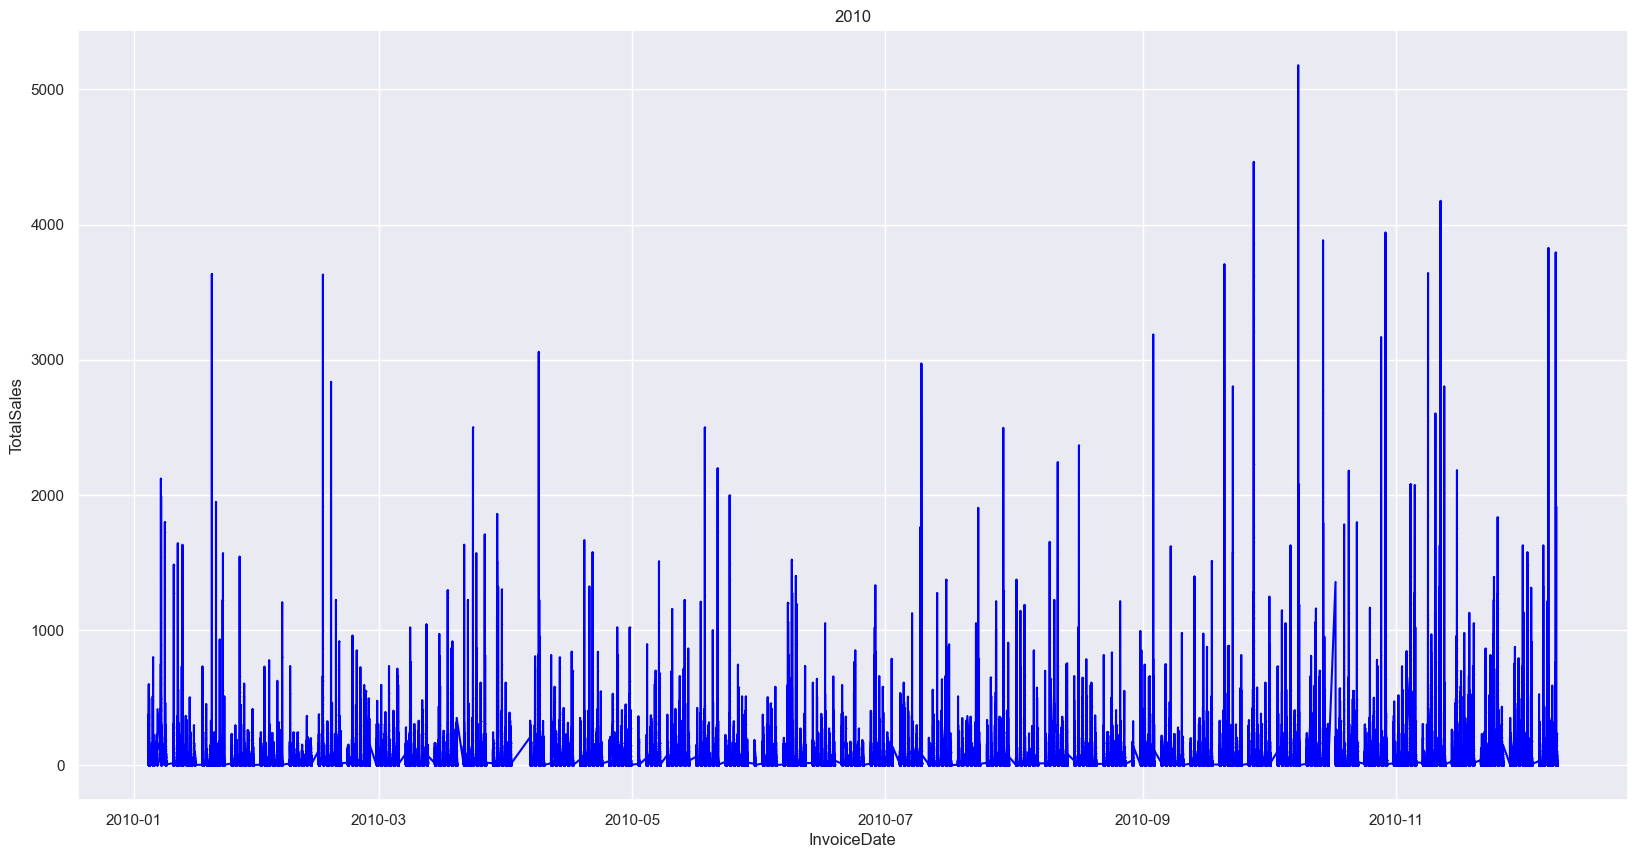

In [14]:
plt.figure(figsize=(20, 10))
plt.plot(df10['InvoiceDate'], df10['TotalSales'], color='blue', marker='o', ms=0.1, linestyle='-')
plt.xlabel('InvoiceDate')
plt.ylabel('TotalSales')
plt.title('2010')
plt.grid(True)
plt.show()

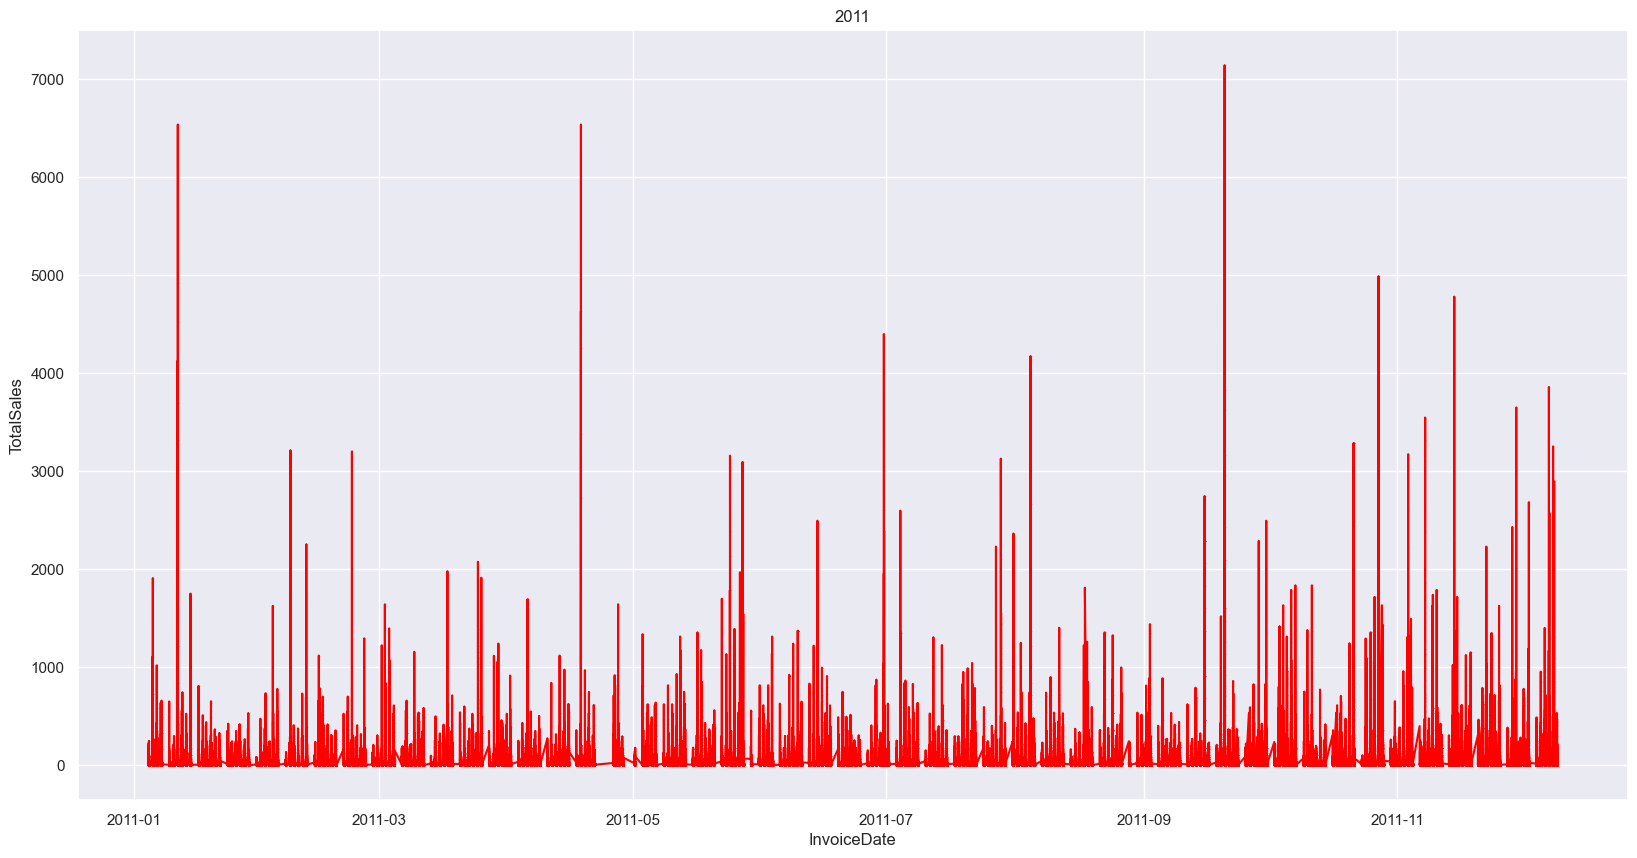

In [15]:
plt.figure(figsize=(20, 10))
plt.plot(df11['InvoiceDate'], df11['TotalSales'], color='red', marker='o', ms=0.1, linestyle='-')
plt.xlabel('InvoiceDate')
plt.ylabel('TotalSales')
plt.title('2011')
plt.grid(True)
plt.show()

Make sure both year data have the same range

In [16]:
min(df10['InvoiceDate']), max(df10['InvoiceDate'])

(Timestamp('2010-01-04 09:54:00'), Timestamp('2010-12-09 20:01:00'))

In [17]:
min(df11['InvoiceDate']), max(df11['InvoiceDate'])

(Timestamp('2011-01-04 10:00:00'), Timestamp('2011-12-09 12:50:00'))

Import the time series forecasting model

In [18]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [19]:
from prophet import Prophet

In [20]:
df10.set_index('InvoiceDate', inplace=True)
df11.set_index('InvoiceDate', inplace=True)

df10_daily = df10.groupby(pd.Grouper(freq='D')).sum()
df11_daily = df11.groupby(pd.Grouper(freq='D')).sum()

Due to large size, we condense the data by aggregating daily sales

In [21]:
df10_daily.reset_index(inplace=True)
df10_daily = df10_daily.rename(columns={'InvoiceDate': 'ds','TotalSales': 'y'})

In [22]:
df11_daily.reset_index(inplace=True)
df11_daily = df11_daily.rename(columns={'InvoiceDate': 'ds','TotalSales': 'y'})

Reset index after remove outliers

In [23]:
model = Prophet()
model.fit(df10_daily)

02:33:36 - cmdstanpy - INFO - Chain [1] start processing
02:33:36 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
future_dates = pd.date_range(start ="2011-01-04", end ="2011-12-09") 
future = pd.DataFrame(future_dates, columns=['ds'])
forecast = model.predict(future)

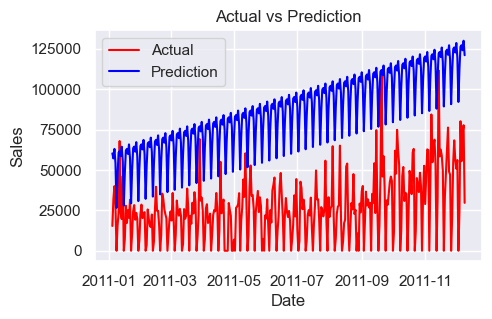

In [25]:
plt.figure(figsize=(5,3))
plt.plot(df11_daily['ds'], df11_daily['y'], color='red', label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], color='blue', label='Prediction')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs Prediction')
plt.legend()
plt.show()

02:33:37 - cmdstanpy - INFO - Chain [1] start processing
02:33:37 - cmdstanpy - INFO - Chain [1] done processing


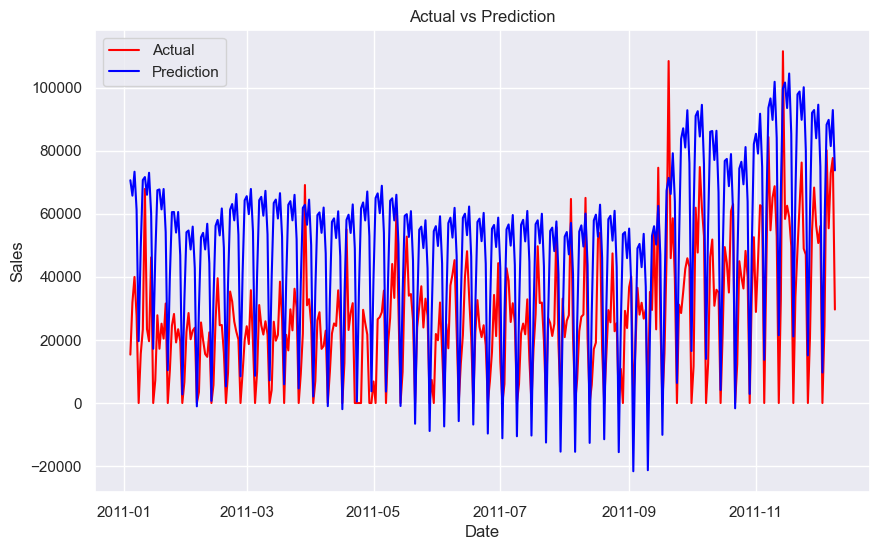

In [26]:
model = Prophet(seasonality_mode='multiplicative',weekly_seasonality=True,daily_seasonality = True,yearly_seasonality = True)
model.fit(df10_daily)

future_dates = pd.date_range(start ="2011-01-04", end ="2011-12-09") 
future = pd.DataFrame(future_dates, columns=['ds'])
forecast = model.predict(future)

plt.figure(figsize=(10, 6))
plt.plot(df11_daily['ds'], df11_daily['y'], color='red', label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], color='blue', label='Prediction')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs Prediction')
plt.legend()
plt.show()

Import the metric to evaluate prediction accuracy

In [27]:
from sklearn.metrics import mean_squared_error

def RMSE(actual,predict):
    rmse = np.sqrt(mean_squared_error(actual, predict))
    print(f'RMSE: {rmse}')

In [28]:
RMSE(df11_daily['y'],forecast['yhat'])

RMSE: 28758.700857561766


In [29]:
from sklearn.model_selection import ParameterGrid

# Define the parameter grid for grid search
params_grid = {'changepoint_prior_scale': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
               'n_changepoints': [50, 75, 100, 125, 150, 175, 200]}

# Initialize an empty dictionary to store the best parameters
best_params = {}
min_rmse = 28758.700857561766  # Set an initial high value for RMSE

# Generate all combinations of parameters from the grid
grid = ParameterGrid(params_grid)

for params in grid:
    # Initialize Prophet model with current parameter combination
    model = Prophet(seasonality_mode='multiplicative',
                    weekly_seasonality=True,
                    daily_seasonality=True,
                    yearly_seasonality=True,
                    changepoint_prior_scale=params['changepoint_prior_scale'], 
                    n_changepoints=params['n_changepoints'])
    
    # Fit the model
    model.fit(df10_daily)
    
    # Make predictions
    future_dates = pd.date_range(start="2011-01-04", end="2011-12-09") 
    future = pd.DataFrame(future_dates, columns=['ds'])
    forecast = model.predict(future)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(df11_daily['y'], forecast['yhat']))
    
    # Update best parameters if current RMSE is lower
    if rmse < min_rmse:
        min_rmse = rmse
        best_params = params

print('Best parameters: ', best_params)
print('Best RMSE: ', min_rmse)

02:33:38 - cmdstanpy - INFO - Chain [1] start processing
02:33:38 - cmdstanpy - INFO - Chain [1] done processing
02:33:39 - cmdstanpy - INFO - Chain [1] start processing
02:33:39 - cmdstanpy - INFO - Chain [1] done processing
02:33:39 - cmdstanpy - INFO - Chain [1] start processing
02:33:39 - cmdstanpy - INFO - Chain [1] done processing
02:33:40 - cmdstanpy - INFO - Chain [1] start processing
02:33:40 - cmdstanpy - INFO - Chain [1] done processing
02:33:40 - cmdstanpy - INFO - Chain [1] start processing
02:33:40 - cmdstanpy - INFO - Chain [1] done processing
02:33:41 - cmdstanpy - INFO - Chain [1] start processing
02:33:41 - cmdstanpy - INFO - Chain [1] done processing
02:33:41 - cmdstanpy - INFO - Chain [1] start processing
02:33:41 - cmdstanpy - INFO - Chain [1] done processing
02:33:42 - cmdstanpy - INFO - Chain [1] start processing
02:33:42 - cmdstanpy - INFO - Chain [1] done processing
02:33:42 - cmdstanpy - INFO - Chain [1] start processing
02:33:42 - cmdstanpy - INFO - Chain [1]

Best parameters:  {'changepoint_prior_scale': 0.05, 'n_changepoints': 50}
Best RMSE:  27936.412978821703


02:34:02 - cmdstanpy - INFO - Chain [1] start processing
02:34:02 - cmdstanpy - INFO - Chain [1] done processing


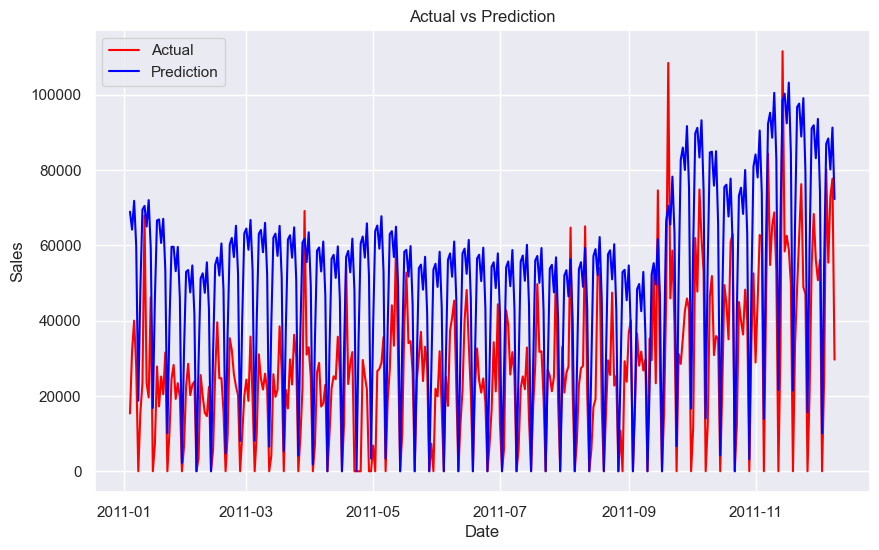

In [30]:
model = Prophet(seasonality_mode='multiplicative',
                weekly_seasonality=True,
                daily_seasonality=True,
                yearly_seasonality=True,
                changepoint_prior_scale=0.05,
                n_changepoints=50)

model.fit(df10_daily)

future_dates = pd.date_range(start ="2011-01-04", end ="2011-12-09") 
future = pd.DataFrame(future_dates, columns=['ds'])
forecast = model.predict(future)

# Ensure non-negative forecasted values
forecast['yhat'] = forecast['yhat'].clip(lower=0)
plt.figure(figsize=(10, 6))
plt.plot(df11_daily['ds'], df11_daily['y'], color='red', label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], color='blue', label='Prediction')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs Prediction')
plt.legend()
plt.show()